# Captain Cook: the fabulous recipes explorator



Objectives:

- [X] Create our own JSON map to plot informations about the recipes by region more specifically
- [Pending] Make the map more interactive and correct the colormap issue
- [Pending] Finish the ingredients list cleaning
- [X] Use statistical properties of the English language or Levenshtein distance
- [Pending] Create a user friendly recipe finder 


Bonus:

- Try to compute missing nutritional informations
- Find meaningful substitutions for ingredients

In [1]:
# Basic imports
import re
import os.path
import numpy as np
import scipy as sp
import pandas as pd

# Map-related imports
import json
import branca
import folium
from pandas.io.json import json_normalize
from IPython.core.display import display, HTML

# Plot-related imports
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
# General parameters
%matplotlib inline
plt.style.use('seaborn')#switch to seaborn style
plt.rcParams["figure.figsize"] = [16,10]

DATA_FOLDER = './data/'

# 1. Data Loading
  
The Data has been fetched and cleaned with `BASH`scripts, please look in the *dataCleaning* section to understand how this was achieved.  

**Home made fetched dataset:**

In [3]:
# Importing ingredients to Pandas DF
allrecipes_df = pd.read_csv(DATA_FOLDER + 'allrecipes.csv', sep='\t',  header=None, encoding = "utf-8")
allrecipes_df.columns = ['ID', 'Region', 'Title', 'Ingredients', 'kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol']

# Bug?? need to convert into numeric somes, TODO EFFICIENT WAY TO DO THIS???
allrecipes_df['kcal'] = pd.to_numeric(allrecipes_df['kcal'], errors='coerce')
allrecipes_df['carb'] = pd.to_numeric(allrecipes_df['carb'], errors='coerce') / 1000.0 # convert to g
allrecipes_df['fat'] = pd.to_numeric(allrecipes_df['fat'], errors='coerce') / 1000.0 # convert to g
allrecipes_df['protein'] = pd.to_numeric(allrecipes_df['protein'], errors='coerce')
allrecipes_df['sodium'] = pd.to_numeric(allrecipes_df['sodium'], errors='coerce') / 1000.0
allrecipes_df['cholesterol'] = pd.to_numeric(allrecipes_df['cholesterol'], errors='coerce')

# Remove any rows which isn't properly formatted
allrecipes_df = allrecipes_df.dropna()

# Remove any duplicated lines
allrecipes_df = allrecipes_df.drop_duplicates().set_index('ID')

# Printing
allrecipes_df.head(5)

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,2 cups persimmon pulp |2 eggs |1 cup white sug...,278.0,53.9,3.8,7.8,0.224,35.0
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,1 cup all-purpose flour |2 tablespoons cornsta...,409.0,43.0,18.8,17.3,0.407,54.0
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,8 bratwurst |2 (12 fluid ounce) cans or bottle...,377.0,12.8,27.4,13.8,1.046,69.0
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,2/3 cup hot pepper sauce (such as Frank&#39;s ...,104.0,0.4,11.6,0.2,0.576,31.0
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,"1 cup butter, softened |1 1/2 cups brown sugar...",140.0,14.9,8.7,1.5,0.076,22.0


In [4]:
# Importing descriptions to Pandas DF
allrecipes_desc_df = pd.read_csv(DATA_FOLDER + 'allrecipes_desc.csv', sep='£',  header=None, encoding = "utf-8",  engine='python')
allrecipes_desc_df.columns = ['ID', 'Description']

# Remove any duplicated lines
allrecipes_desc_df = allrecipes_desc_df.drop_duplicates().set_index('ID')

allrecipes_desc_df.head(5)

,Description
ID,
b9705d990df6857f20756fc996a54b63,Preheat the oven to 350 degrees F (175 degree...
4658708d644d7b446d843fed5ddf60c4,"To make beer batter: In a large bowl, combine..."
beed004e2a1772ba0db9da913f54122e,"Place bratwurst, beer, onion, and ketchup in ..."
96353c72421bd74096277c6cf8b17097,"Combine the hot sauce, butter, vinegar, Worce..."
ee659a6a5e69834b60744cc3e103729e,Preheat oven to 350 degrees F (175 degrees C)...


In [5]:
print("Number of recipes:", len(allrecipes_df.index.unique()))

Number of recipes: 15894


**Provided Dataset**

This dataset was provided with the assignment and cleaned with the provided `Perl` scripts. 

Thanks to the scripts, we obtain two datasets:

1. `cleaned_ing.csv` contains the list of ingredients for each recipe,
2. `cleaned_nutri.csv` contains the corresponding nutritional values.

Our objective is to merge these two sets to obtain a unique set with all useful informations.

In [6]:
# Importing ingredients to Pandas DF
ing_df = pd.read_csv(DATA_FOLDER + 'cleaned_ing.csv', sep='\t',  header=None, encoding = "utf-8")
ing_df.columns = ['ID', 'Title', 'Ingredients']

# Importing nutritional values to Pandas DF
nutri_df = pd.read_csv(DATA_FOLDER + 'cleaned_nutri.csv', sep='\t',  header=None, encoding = "utf-8")
nutri_df.columns = ['ID', 'kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol']

# Merging
ing_df = ing_df.set_index('ID')
nutri_df = nutri_df.set_index('ID')
provided_df = ing_df.merge(nutri_df, on='ID', how='inner')

# Drop NaNs and duplicate lines
provided_df = provided_df.dropna().drop_duplicates()

provided_df.head()

,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,
38e1b80017526d6e59ed3f986c35a43a,T.G.I. Friday's Jack Daniels Sauce Recipe #10265,1 teaspoon onion powder|1 tablespoon Tabasco s...,?,?,?,?,?,?
a3636a4dab434fe21fbcdceba7d6fcf2,Simple Peanut Squash Recipe,1 butternut squash|2 tablespoons brown sugar|1...,536,86.4,23.6,6.5,483,61
117f3c214e9de550a157ce5ee1f1cceb,Hash Brown Breakfast Casserole Recipe,"1 lb ground sausage (""hot"" or ""sage"" flavored)...",660.4,24.7,47.3,32.5,1248.0,251.6
fde8f280a690fb8bc77c10a7193db08b,Basic Homemade Country Sausage Recipe,2 pounds lean pork|1/2 pound pork fatback|3 te...,?,?,?,?,?,?
714df642f50b9ae489d285e16b59bf7b,Spinach Frittata Recipe,1 cup fresh spinach|2 egg whites|1 egg yolk|1/...,?,?,?,?,?,?


We can observe that some nutritional values are missing, which can be solved either by removing the lines or by trying to calculate these values from the given ingredients.

As trying to calculate the values from ingredients with different units (i.e. grams, cups, tbsp, etc) requires a set of informations that we do not have, we decided to leave these lines as they are for now. 

In [7]:
# Bug?? need to convert into numeric somes, TODO EFFICIENT WAY TO DO THIS???
provided_df['kcal'] = pd.to_numeric(provided_df['kcal'], errors='coerce')
provided_df['carb'] = pd.to_numeric(provided_df['carb'], errors='coerce')
provided_df['fat'] = pd.to_numeric(provided_df['fat'], errors='coerce')
provided_df['protein'] = pd.to_numeric(provided_df['protein'], errors='coerce')
provided_df['sodium'] = pd.to_numeric(provided_df['sodium'], errors='coerce')
provided_df['cholesterol'] = pd.to_numeric(provided_df['cholesterol'], errors='coerce')

# Insert Region column to match the other DF
provided_df.insert(loc=1, column='Region', value=np.nan)
provided_df.head(5)

,Title,Region,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,,
38e1b80017526d6e59ed3f986c35a43a,T.G.I. Friday's Jack Daniels Sauce Recipe #10265,NaN,1 teaspoon onion powder|1 tablespoon Tabasco s...,NaN,NaN,NaN,NaN,NaN,NaN
a3636a4dab434fe21fbcdceba7d6fcf2,Simple Peanut Squash Recipe,NaN,1 butternut squash|2 tablespoons brown sugar|1...,536.0,86.4,23.6,6.5,483.0,61.0
117f3c214e9de550a157ce5ee1f1cceb,Hash Brown Breakfast Casserole Recipe,NaN,"1 lb ground sausage (""hot"" or ""sage"" flavored)...",660.4,24.7,47.3,32.5,1248.0,251.6
fde8f280a690fb8bc77c10a7193db08b,Basic Homemade Country Sausage Recipe,NaN,2 pounds lean pork|1/2 pound pork fatback|3 te...,NaN,NaN,NaN,NaN,NaN,NaN
714df642f50b9ae489d285e16b59bf7b,Spinach Frittata Recipe,NaN,1 cup fresh spinach|2 egg whites|1 egg yolk|1/...,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Number of recipes:", len(provided_df.index.unique()))

Number of recipes: 31376


In [9]:
# Concatenate the 2 DF and drop any duplicated lines, it is possible since some data come from the same website!
recipes_df = allrecipes_df.append(provided_df, sort=False).drop_duplicates()
recipes_df['Region'] = recipes_df['Region'].astype('category')

recipes_df.head()

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,2 cups persimmon pulp |2 eggs |1 cup white sug...,278.0,53.9,3.8,7.8,0.224,35.0
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,1 cup all-purpose flour |2 tablespoons cornsta...,409.0,43.0,18.8,17.3,0.407,54.0
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,8 bratwurst |2 (12 fluid ounce) cans or bottle...,377.0,12.8,27.4,13.8,1.046,69.0
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,2/3 cup hot pepper sauce (such as Frank&#39;s ...,104.0,0.4,11.6,0.2,0.576,31.0
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,"1 cup butter, softened |1 1/2 cups brown sugar...",140.0,14.9,8.7,1.5,0.076,22.0


In [10]:
print("Number of total recipes:", len(recipes_df.index.unique()))

Number of total recipes: 46999


In [11]:
len(recipes_df[recipes_df['Region']=='italian'])/365

6.841095890410959

We see that the total number of recipes is enough to eat italian recipes everyday for almost 7 years!!  
We can save this DataFrame to be use later on.

In [12]:
recipes_df.to_csv(DATA_FOLDER + 'recipes_df.csv', sep='\t', encoding='utf-8')

# 2. Ingredient parsing
The cleaning is presented in `DataCleaning.ipynb`, here we use directly the result which is a list of good ingredient that can be matched in the recipes and are relevant for any statistical analysis

In [13]:
# Load csv file 'hand' cleaned
with open(DATA_FOLDER + 'cleaned_list') as f:
    ing_list = f.read().splitlines()
    
# Load the dictionnary that correct the name mispelled
ing_dict = np.load(DATA_FOLDER + 'ing_dict.npy').item()

In [14]:
# USEFUL
recipes_copy = recipes_df.copy()
recipes_copy['Ingredients'] = recipes_copy['Ingredients'].str.lower()

# Remove non alphabetic values expect of '|' which is the seperating char
recipes_copy['Ingredients'] = recipes_copy['Ingredients'].str.replace('[^a-zA-Z ]+', ' ')

In [15]:
# This step is needed to clean the dataset ingredient!
# Function that apply the cleaning dictionnary on every word in ingredients column for each recipes
def matcher(k):
    x = (i for i in ing_dict if i in k.split(' '))
    return '|'.join(map(ing_dict.get, x))

# Cleaned!!!
recipes_copy['Cleaned_Ing'] = recipes_copy['Ingredients'].map(matcher)
recipes_copy

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol,Cleaned_Ing
ID,,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,cups persimmon pulp eggs cup white sugar...,278.0,53.9,3.8,7.8,0.224,35.0,butter|flour|milk|eggs|persimmon
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,cup all purpose flour tablespoons cornstar...,409.0,43.0,18.8,17.3,0.407,54.0,salt|pepper|flour|powder|cumin|lime|corn|mayon...
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,bratwurst fluid ounce cans or bottles b...,377.0,12.8,27.4,13.8,1.046,69.0,onion|beef
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,cup hot pepper sauce such as frank s redhot...,104.0,0.4,11.6,0.2,0.576,31.0,salt|pepper|butter|powder|vinegar|worcestershire
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,cup butter softened cups brown sugar ...,140.0,14.9,8.7,1.5,0.076,22.0,salt|butter|flour|powder|milk|eggs|vanilla|cho...
1afe62458129f741d989b89d6ae8d08c,us,Kendra's Maid-Rite Sandwiches,pounds ground beef chopped onion cup ket...,244.0,27.0,8.9,13.4,0.483,34.0,salt|onion|vinegar|beef|worcestershire|hamburger
7b93a05f2c4a9ff967957f62fe5c6622,us,Amish White Bread,cups warm water degrees f degrees c cu...,168.0,30.7,2.9,4.4,0.147,0.0,salt|flour|water|bread|yeast
fb0673097182df2dd7f7355b0e41693a,us,Buffalo Chicken Dip,ounce cans chunk chicken drained oun...,284.0,8.6,22.6,11.1,0.552,54.0,pepper|chicken|cream|celery|cheddar|cracker
1eaa22e1674b18dfbd30ec384931e9b1,us,Roast Sticky Chicken-Rotisserie Style,teaspoons salt teaspoons paprika teaspoo...,586.0,3.7,34.3,61.7,1.351,194.0,salt|pepper|onion|powder|onion|chicken


----
**The ingredient is now perfectly cleaned we can do some neat analysis on it**

In [16]:
# Expand the cleaned ingredient for each recipes
matrix = recipes_copy['Cleaned_Ing'].str.get_dummies('|')
matrix.head()

,achiote,acini,adobo,adzuki,agar,aioli,ajies,ajinomoto,alcohol,alfalfa,...,yoplait,yucca,zapallo,zape,zesty,zinfandel,ziploc,ziti,zucchini,zwieback
ID,,,,,,,,,,,,,,,,,,,,,
b9705d990df6857f20756fc996a54b63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4658708d644d7b446d843fed5ddf60c4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
beed004e2a1772ba0db9da913f54122e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96353c72421bd74096277c6cf8b17097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ee659a6a5e69834b60744cc3e103729e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Convert to numpy array for mathematic manipulations
X = matrix.values

# Compute the adjacency of the ingredient Graphs
# Indeed, since each values belong to the set {0,1}
# we get a matrix which corresponds to the number of link
# between two ingredients, it is define by the number at a given line - column
# TODO explanation

adjacency = X.T @ X

In [18]:
import networkx as nx
matrix = recipes_copy[recipes_copy['Region'] == 'us']['Cleaned_Ing'].str.get_dummies('|')
X = matrix.values
adjacency = X.T @ X
G = nx.from_numpy_matrix(adjacency)

In [19]:
Gc = max(nx.connected_component_subgraphs(G), key=len)
L = nx.normalized_laplacian_matrix(Gc)
Laplacian = L.toarray()
Laplacian

array([[ 0.92307692,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.91390728,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.83333333, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.88607595,
        -0.00356856,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.00356856,
         0.89336016,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.89473684]])

In [20]:
from scipy import linalg
e, v = np.linalg.eigh(Laplacian) # Ordered Laplacian eigenvalues.
v

array([[ 7.61027345e-03, -2.44521282e-06, -4.73740395e-07, ...,
        -3.02168426e-02,  8.63595142e-03, -1.44489230e-04],
       [ 3.66802306e-02,  3.84171380e-02,  4.85533530e-02, ...,
        -2.68153626e-02, -9.55380573e-03, -8.16847522e-02],
       [ 5.17016271e-03, -6.43635425e-03,  1.40366426e-02, ...,
        -3.86587076e-02,  9.74377669e-02,  1.85900994e-01],
       ...,
       [ 2.65312144e-02,  6.00757343e-02,  2.39346047e-02, ...,
         1.23655647e-01, -3.04351246e-01, -3.10713419e-01],
       [ 4.70551086e-02,  3.49711674e-03, -2.76442113e-02, ...,
         7.64314785e-02, -1.73773989e-02, -4.74305403e-02],
       [ 9.20037197e-03,  4.86198413e-02, -5.32258195e-02, ...,
        -2.13561221e-01,  1.42941470e-01, -1.12086821e-01]])

In [21]:
labels={}
labels[0]=r'$a$'
labels[1]=r'$b$'
labels[2]=r'$c$'
labels[3]=r'$d$'
labels[4]=r'$\alpha$'
labels[5]=r'$\beta$'
labels[6]=r'$\gamma$'
labels[7]=r'$\delta$'
matrix.columns.tolist()[0]

'achiote'

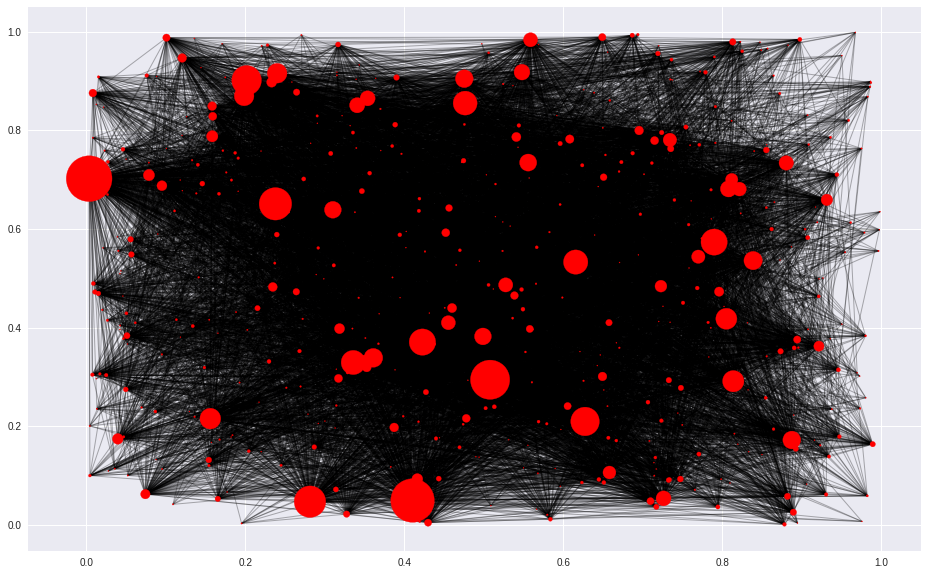

In [23]:
coords = nx.random_layout(Gc)  # Force-directed layout.
#coords = v[:, 1:3]  # Laplacian eigenmaps.
nx.draw_networkx_nodes(Gc, coords, node_size=np.diag(adjacency), labels = 'gla')
nx.draw_networkx_edges(Gc, coords, alpha=0.3, edge_cmap='Spectral')
#nx.draw_networkx_labels(Gc, coords,dict.fromkeys(matrix.columns.tolist(),1),font_size=matrix.columns.str)

In [24]:
# Graph Plotting

# TODO: that would be nice https://www.curiousgnu.com/reddit-comments

-----
**Test with Holoviews**

In [37]:
df = pd.DataFrame(data=adjacency,    # values
...               index=matrix.columns,    # 1st column as index
...               columns=matrix.columns)  # 1st row as the column names

df = df.unstack().to_frame().reset_index().drop_duplicates()
df.columns = ['src', 'trg', 'number']
df = df.nlargest(200, columns='number')
df

,src,trg,number
191981,salt,salt,2093
161048,pepper,pepper,1897
148282,onion,onion,1541
161111,pepper,salt,1420
191918,salt,pepper,1420
148308,onion,pepper,1230
161022,pepper,onion,1230
27496,butter,butter,1056
148371,onion,salt,1038
191892,salt,onion,1038


In [38]:
#import numpy as np
#import pandas as pd
#import holoviews as hv
#hv.extension('bokeh')
#%output fig='html' size=300

#%opts Chord [label_index='index' color_index='src' edge_color_index='src'] 
#%opts Chord (cmap='Category20' edge_cmap='Category20')
#hv.Chord(df)

---

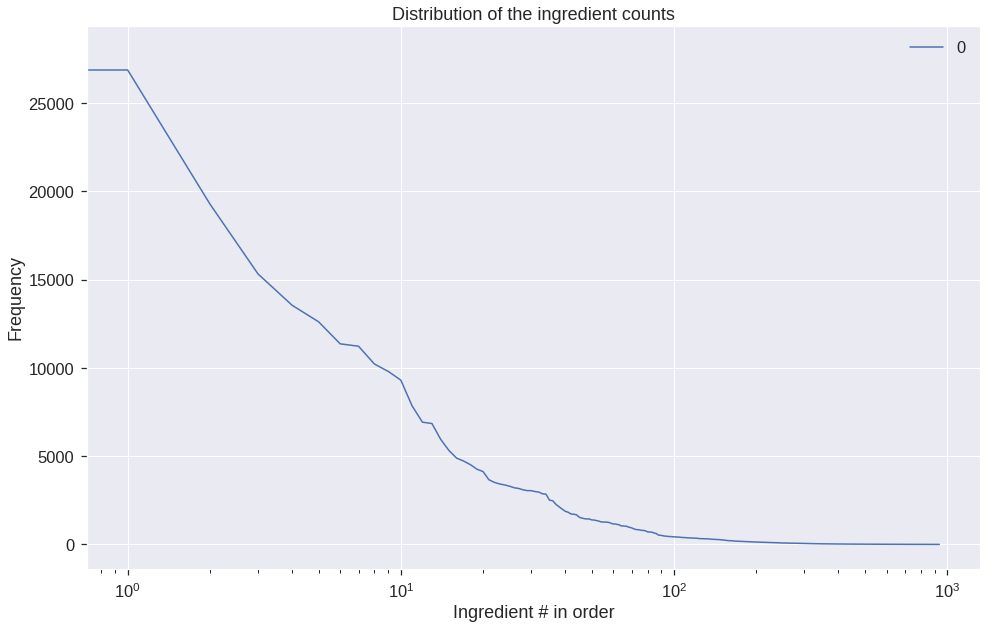

In [39]:
# Count occurences
ing_ds = recipes_copy['Ingredients'].str.split(" ", expand=True) \
                                    .stack() \
                                    .map(ing_dict) \
                                    .value_counts()  \
                                    .to_frame()  \
                                    .reset_index()

# TODO THIS SHOULD BE MOVE BELOW, IT IS AN ANALYSIS -> Quite useless but hey :P
ing_ds.plot()

plt.xscale("log")
plt.xlabel('Ingredient # in order')
plt.ylabel('Frequency')
plt.title('Distribution of the ingredient counts')
plt.show()

# 3. Cooking time study-case

In this part we would like to analyze the cooking time of the recipes to be able to classify which regions have the highest and lowest cooking time.

In [40]:
# Extract all timing from recipes
timing_df = allrecipes_desc_df['Description'].str.extractall(r'(\d+) minutes|(\d+) hour|hours')
timing_df.columns = ['minutes', 'hours']

#Replace Nan by 0 and switch to int type
timing_df = timing_df.fillna(0).astype(int)

#Sum the number of minutes to get the recipe time
timing_df['Time (min)'] = timing_df['minutes']+timing_df['hours']*60

timing_df.head()

minutes  hours  Time (min)
ID                               match                            
b9705d990df6857f20756fc996a54b63 0            0      2         120
                                 1           15      0          15
beed004e2a1772ba0db9da913f54122e 0            0      4         240
                                 1            5      0           5
ee659a6a5e69834b60744cc3e103729e 0           12      0          12

In [41]:
# Sum the total amount of time for each recipe
time_recipe = timing_df.groupby('ID').agg('sum')
time_recipe = time_recipe.drop(['minutes','hours'], axis=1)

time_recipe.head()

,Time (min)
ID,
00035a69b44a9dd1f88f2bb5faced261,90
000d31e632cab9e6902f05196354a007,660
0015417d2473d92a56da28883a27aff3,120
001cf1a5a0d1914f958cb2c823df6121,8
001f5efe07f4c72b4aaf846ec7616aba,13


# 4. Merging
Finally, we can merge everything to a single DataFrame to use it for Visualization

In [42]:
# Merging Cooking Time
cleaned_df = recipes_df.merge(time_recipe, on='ID', how='left')

# Cleaning ingredient and ingredient substition
# This is not yet implemented but we are close to achieve this

cleaned_df.sample(5)

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol,Time (min)
ID,,,,,,,,,,
18294171283e54af4d72db525a90e191,NaN,Paula Deen's Banana Nut Bread Recipe,1/2 cup Crisco shortening|1 cup sugar|2 cups a...,216.7,30.4,9.6,3.3,245.0,23.4,NaN
0f985ae7074fa34b9029ddc8eca59c35,NaN,Eastern Shore Crab Imperial Recipe,"1 pound lump crabmeat, bits of shell and carti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
63082c361bb4b25184e7b4169e061534,NaN,Meatless Loaf Recipe,1 (12 ounce) package vegetarian burger crumble...,125.0,10.2,4.6,10.4,496.0,53.0,NaN
6a7abdbb1f5e2ec159c4c6fc0e57342e,NaN,Muffin Sized Breakfast Quiche Recipe,9 eggs|1 (10 ounce) bag baby spinach|1 medium ...,269.7,5.2,19.3,18.7,311.8,404.4,NaN
d9c4bf86d2360da9c78a19af697672ca,NaN,Jackie's Crab and Shrimp Dip Recipe,"4 (8 ounce) packages cream cheese|1 tomato, ch...",232.0,3.0,20.0,10.6,251.0,94.0,NaN


# 5. Analysis

This part presents some basic statistical analysis of the data.

First we analyse the data by region and observe *mean*, *median*, *min* and *max* for each nutritional value.

In [43]:
# Some classic analysis
stats_regions = cleaned_df.groupby('Region')
stats_regions = stats_regions.agg({'kcal' : ['mean', 'median', 'min', 'max'],
                                       'carb' : ['mean', 'median', 'min', 'max'],
                                       'fat' : ['mean', 'median', 'min', 'max'],
                                       'protein' : ['mean', 'median', 'min', 'max'],
                                       'sodium' : ['mean', 'median', 'min', 'max'],
                                       'cholesterol' : ['mean', 'median', 'min', 'max'],
                                       'Time (min)' : ['mean', 'median', 'min', 'max']})
stats_regions.sort_values([('kcal', 'mean')], ascending=False).head()

kcal                            carb                     \
                  mean median   min     max       mean median  min    max   
Region                                                                      
malaysian   435.600000  427.0  33.0  1238.0  30.422857  26.70  1.7  113.2   
portuguese  402.173333  378.0  27.0  2266.0  33.832000  28.50  4.0  108.6   
italian     391.215459  360.0   4.0  1641.0  34.242171  29.90  0.0  174.8   
indonesian  387.648649  401.0  65.0   716.0  29.056757  19.60  6.5   94.2   
french      377.932609  319.5   9.0  3274.0  27.991739  22.05  0.4  240.9   

                  fat          ...   sodium         cholesterol              \
                 mean median   ...      min     max        mean median  min   
Region                         ...                                            
malaysian   24.091429  19.80   ...    0.011   3.031   90.914286   66.0  0.0   
portuguese  20.009333  17.10   ...    0.003  10.693   84.986667   67.0  0.0   
italian     19.998438  17.20   ...    0.001   7.648   71.113736   50.0  0.0   
indonesian  21.545946  19.00   ...    0.004   2.459   97.918919   68.0  0.0   
french      22.572391  18.15   ...    0.002   8.623  100.473913   73.5  0.0   

                   Time (min)                      
              max        mean median  min     max  
Region                                             
malaysian   340.0   88.424242   30.0  2.0  1460.0  
portuguese  389.0  188.071429   50.0  2.0  1533.0  
italian     734.0   89.862860   39.0  0.0  2160.0  
indonesian  500.0   68.972222   28.5  3.0   380.0  
french      780.0  120.860294   45.0  2.0  2880.0  

[5 rows x 28 columns]

# 6. Visualization

In this part we present the overall visualization of informations we retrieve in the dataset.

###  Plots

In [44]:
# Interactive plot of correlation between nutritive values 
def f(nutritive1, nutritive2):
    
    sns.set_context("notebook", font_scale=1.5)
    sns.scatterplot(cleaned_df[nutritive1], cleaned_df[nutritive2])
    plt.show()
    
# Interact
interact(f, nutritive1=['kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol'],
            nutritive2=['kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol']);

interactive(children=(Dropdown(description='nutritive1', options=('kcal', 'carb', 'fat', 'protein', 'sodium', …

In the plot above we can see the correlation between the different nutritional values. 

For example, there are many recipes where high carbs and fats correspond to high caloric plates, but less so for high proteins. Also it would seem that fats and cholesterol are not as correlated as we would think.

Below is a plot that shows the correlation coefficient for pairs of nutritional values by region. 

In [45]:
# Correlation between nutritional values shown per region
def f(region):
    sns.set_context("notebook", font_scale=1.5)
    
    # .iloc[:,:-1] is to avoid the Time column
    # It can be interesting to see if there is a correlation
    corr = cleaned_df.iloc[:,:-1][cleaned_df['Region'] == region].corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()
    
# Interact
interact(f, region=cleaned_df.Region.unique().dropna());

interactive(children=(Dropdown(description='region', options=('us', 'korean', 'japanese', 'indonesian', 'thai'…

Below is a plot that shows the statistics by nutritional or time value of recipes classified by region. The plot is automatically ordered by median, so we obtain the region with the highest median for that item value.

In [46]:
# Item value statistics by regions
def f(item):
    recipe_sorted = stats_regions.sort_values([(item, 'median')], ascending=False)

    sns.set_context("notebook", font_scale=1.5)
    sns.boxplot(cleaned_df[item], cleaned_df['Region'], order=recipe_sorted.index)
    
    ## There is a big outlier for Sodium & Time, we will handle it later
    if(item == 'sodium'):
        plt.xlim(-0.5, 10)
        
    if(item == 'Time (min)'):
        plt.xlim(-50, 1500)
    ##
    plt.show()
    
# Interact
interact(f, item=['kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol', 'Time (min)']);

interactive(children=(Dropdown(description='item', options=('kcal', 'carb', 'fat', 'protein', 'sodium', 'chole…

We can see that the most calorical, fat and protein rich recipes belong to Malaysia, while the sodium intake is won by the korean recipes. The ones that have to be most careful about the cholesterol intake seem to be the French.

By comparing the median we also see that the longest cooking time and preparation in total is for Persian recipes, whereas Japanese's recipes are the shortest

### Maps

In [47]:
# Loading JSON of world map
map_recipes_json = json.load(open(DATA_FOLDER + 'recipes_map.json'))

In [48]:
def layer_colormap(topojson, df, column, colorscale):
    
    # Create a layer
    feature_map = folium.FeatureGroup(name=column, overlay=False)  

    def style_function(feature):
    # Fetching values for the mean of the category for the given asked continent
        value = df[df['Region'] == feature['properties']['Region']][column].mean()
        return {
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.5,
            'fillColor': '#black' if np.isnan(value) else colorscale(value)
                }
    # Fetch values from the DataFrame and apply the colormap to the values
    # If the value is NaN, the corresponding color is dark-grey
    folium.GeoJson(topojson, style_function=style_function).add_to(feature_map)

    return feature_map;

In [49]:
# Create a new empty map
map_info  = folium.Map([30,0], tiles='cartodbpositron', zoom_start=2)

# Add for each nutritive information the map
for category in ['kcal','carb','fat','protein','sodium','cholesterol', 'Time (min)']:
    colorscale = branca.colormap.linear.YlOrRd_09.scale((min(stats_regions[category]['mean'])), max(stats_regions[category]['mean']))
    layer_colormap(map_recipes_json, cleaned_df, category, colorscale).add_to(map_info)
    
# Add a legend to the colormap and append it to the base layer
colorscale.caption = 'Mean of the nutritive value selected'
map_info.add_child(colorscale) 

# Adding the tile Layer thus it is prettier
folium.TileLayer(tiles='cartodbpositron', overlay=True).add_to(map_info)

# Layer Control to select the different layer created before
folium.LayerControl(collapsed=False, position='bottomleft').add_to(map_info);

# Save/Display
map_info.save('map_info.html')
#map_info

In [50]:
%%HTML
<iframe src="map_info.html" width=100% height=700></iframe>

On the previous map, we can see how the different nutritive properties of the recipes vary through the different continents. We can thus see some correlations like the kcal of the recipe and the fat which are both high in the same continents.  

**Note:** we actually have a small issue with the colormap and we will be fixing it by using a different kind of interactive map to show more interesting information (Ingredients distribution, min/max or median for nutrition)

In [ ]:


layers=[dict(sourcetype = 'geojson',
             source =sources[k],
             below="water",
             type = 'fill',
             color = facecolor[k],#the list of colors for each shape/layer in choropleth
             opacity=0.8
            ) for k in range(len(sources))]